<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [3]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [4]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [30]:
def plot_validation_curves(param_values, grid_cv_results_):
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [8]:
from sklearn.neighbors import KNeighborsClassifier
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

In [9]:
knn = KNeighborsClassifier(n_neighbors=100) # ''' ВАШ КОД ЗДЕСЬ '''

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [11]:
cross_score = round(cross_val_score(knn, X_train, y_train, cv=skf).mean(), 3)
knn.fit(X_train, y_train)
preds = knn.predict(X_valid)
acc_score = round(accuracy_score(y_valid, preds), 3)
write_answer_to_file(str(cross_score) + ' ' + str(acc_score), '4.1.txt')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
forest = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=17)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [14]:
forest.fit(X_train, y_train)
preds = forest.predict(X_valid)
acc_score = round(accuracy_score(y_valid, preds), 3)
oob_score = round(forest.oob_score_, 3)
write_answer_to_file(str(oob_score) + ' ' + str(acc_score),
                     'answer4_2.txt')

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [15]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [16]:
logit = LogisticRegression(random_state=17, n_jobs=-1)
logit.fit(X_train, y_train)
preds = logit.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
cv_score = cross_val_score(logit, X_sparse_10users, y_10users, cv = skf).mean()
print('acc_score: ', acc_score)
print('cv_score: ', cv_score)

acc_score:  0.7767243422611994
cv_score:  0.777398478059882


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [35]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)
gs = GridSearchCV(logit, param_grid = {"C": logit_c_values1}, cv=skf)
gs.fit(X_train, y_train)

Wall time: 1min


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LogisticRegression(n_jobs=-1, random_state=17),
             param_grid={'C': array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])})

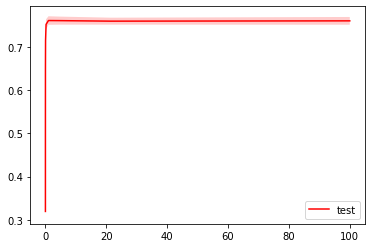

In [42]:
plot_validation_curves( logit_c_values1, gs.cv_results_)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [41]:
logit_mean_cv_scores1 = gs.cv_results_['mean_test_score']


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [48]:
print(gs.best_score_, gs.best_params_)

0.7606189739891912 {'C': 1.0}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

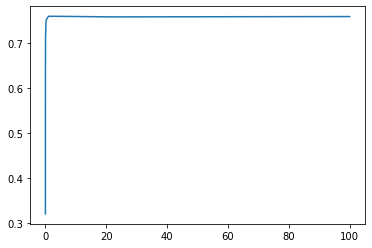

In [43]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [50]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

gs2 = GridSearchCV(logit, param_grid = {"C": logit_c_values2}, cv=skf)
gs2.fit(X_train, y_train)

Wall time: 2min 49s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LogisticRegression(n_jobs=-1, random_state=17),
             param_grid={'C': array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ])})

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

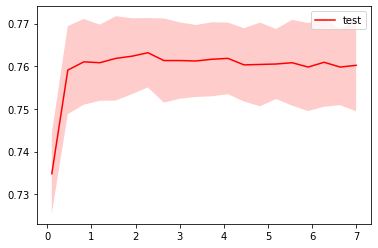

In [52]:
plot_validation_curves( logit_c_values2, gs2.cv_results_)
logit_mean_cv_scores2 = gs2.cv_results_['mean_test_score']

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [53]:
print(gs2.best_score_, gs2.best_params_)

0.7631589739396327 {'C': 2.278947368421053}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

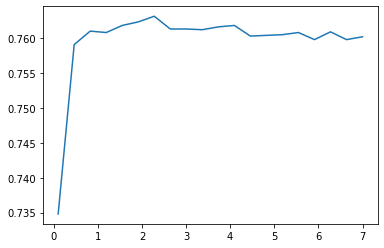

In [54]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [60]:
preds = gs2.best_estimator_.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
print(logit_cv_acc)

0.7826499170419531


**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [63]:
write_answer_to_file(str(round(gs2.best_score_, 3)) + ' ' + str(round(acc_score, 3)),
                     'answer4_3.txt')

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [64]:
from sklearn.svm import LinearSVC

In [70]:
svm = LinearSVC(random_state=17)
cross_score = round(cross_val_score(svm, X_train, y_train, cv=skf).mean(), 3)
svm.fit(X_train, y_train)
preds = svm.predict(X_valid)
acc_score = round(accuracy_score(y_valid, preds), 3)
print(cross_score, acc_score)

0.751 0.777


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [72]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid = svm_params1, cv=skf)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 1min 35s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(random_state=17),
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])})

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [73]:
print(svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_)

0.6959968146237391 {'C': 5555.555600000001}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

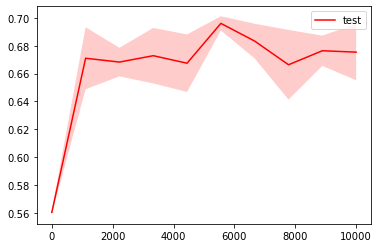

In [74]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [75]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid = svm_params2, cv=skf)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 2min 44s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(random_state=17),
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])})

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [76]:
print(svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_)

0.7670206386611259 {'C': 0.10434482758620689}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

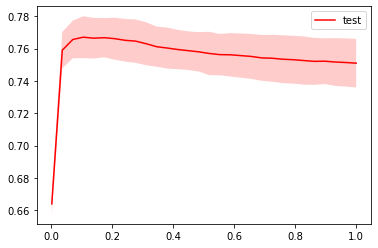

In [77]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [79]:
preds = svm_grid_searcher2.best_estimator_.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [80]:
write_answer_to_file(str(round(gs2.best_score_, 3)) + ' ' + str(round(acc_score, 3)),
                     'answer4_4.txt')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [93]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(path_to_X_pickle, 'rb') as X_users_pkl:
        X_users = pickle.load(X_users_pkl)
    with open(path_to_y_pickle, 'rb') as y_users_pkl:
        y_users = pickle.load(y_users_pkl)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_users, y_users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_users)
    
    cv_score = cross_val_score(estimator, X_train, y_train, cv = cv).mean()
    estimator.fit(X_train, y_train)
    preds = estimator.predict(X_valid)
    acc_score = accuracy_score(y_valid, preds)
    return (cv_score, acc_score)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [ ]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [95]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = PATH_TO_DATA + '//X_sparse_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl'
        path_to_y_pkl = PATH_TO_DATA + '//y10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl'
        print (window_size, session_length, model_assessment(svm_grid_searcher2.best_estimator_,
                                                             path_to_X_pkl, path_to_y_pkl,
                                                             skf, random_state=17, test_size=0.3))

10 15 (0.8243252292702751, 0.8404835269021095)
10 10 (0.7670206386611259, 0.7807537331121118)
7 15 (0.8495024256089474, 0.8543222166915547)
7 10 (0.7983645917156946, 0.8073668491786958)
7 7 (0.754765400423003, 0.7617388418782147)
5 15 (0.8670355547005402, 0.8752963489805595)
5 10 (0.8177520250854086, 0.8245614035087719)
5 7 (0.772939529035208, 0.7853247984826932)
5 5 (0.7254849424351582, 0.7362494073020389)
Wall time: 46 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [97]:
path_to_X_pkl = PATH_TO_DATA + '//X_sparse_10users_s' + str(15) + '_w' + str(5) + '.pkl'
path_to_y_pkl = PATH_TO_DATA + '//y10users_s' + str(15) + '_w' + str(5) + '.pkl'
scores = model_assessment(svm_grid_searcher2.best_estimator_,
                                    path_to_X_pkl, path_to_y_pkl,
                                    skf, random_state=17, test_size=0.3)
write_answer_to_file(str(round(scores[0], 3)) + ' ' + str(round(scores[1], 3)), 'ans_4_5.txt')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [101]:
%%time
estimator = svm_grid_searcher2.best_estimator_
from tqdm import tqdm

ans = []

for window_size, session_length in tqdm([(5,5), (7,7), (10,10)]):
    path_to_X_pkl = PATH_TO_DATA + '//X_sparse_150users_s' + str(session_length) + '_w' + str(window_size) + '.pkl'
    path_to_y_pkl = PATH_TO_DATA + '//y150users_s' + str(session_length) + '_w' + str(window_size) + '.pkl'
    ans.append((window_size, session_length, model_assessment(svm_grid_searcher2.best_estimator_,
                                                             path_to_X_pkl, path_to_y_pkl,
                                                             skf, random_state=17, test_size=0.3)))

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [23:45<00:00, 475.21s/it]

Wall time: 23min 45s


In [102]:
print(ans)

[(5, 5, (0.4083611011164474, 0.42171606560568453)), (7, 7, (0.4366487102001489, 0.45295840855673264)), (10, 10, (0.46307591254574465, 0.4836276942538802))]


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [105]:
str_ans = ''
for score in ans:
    str_ans += str(round(score[2][0], 3))
    str_ans += ' '
    str_ans += str(round(score[2][1], 3))
    str_ans += ' '
write_answer_to_file(str_ans, 'ans_4_6.txt')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [106]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [107]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [129]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[2.278947368421053], multi_class='ovr', random_state=17, n_jobs=-1 )
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 13min 3s


LogisticRegressionCV(Cs=[2.278947368421053], multi_class='ovr', n_jobs=-1,
                     random_state=17)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [131]:
cv_scores_by_user = {}
# scores = np.array()
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format (user_id, logit_cv_150users.scores_[user_id].mean()))
#     scores.append()

User 6, CV score: 0.9961527577866992
User 13, CV score: 0.9964655450515891
User 15, CV score: 0.9953603851957837
User 16, CV score: 0.9920240358961785
User 28, CV score: 0.9903141353701261
User 31, CV score: 0.9942447847668706
User 33, CV score: 0.993869443744973
User 39, CV score: 0.9860915575701783
User 46, CV score: 0.9980190369982573
User 49, CV score: 0.9953395361175481
User 50, CV score: 0.9945679973861662
User 53, CV score: 0.9937756144682744
User 65, CV score: 0.9969138733377759
User 66, CV score: 0.9947452354768836
User 82, CV score: 0.9963195775888373
User 85, CV score: 0.9963508607178794
User 89, CV score: 0.9907103330796104
User 92, CV score: 0.9944637351457113
User 100, CV score: 0.9946514045696098
User 102, CV score: 0.9914505919431006
User 103, CV score: 0.9809410536569418
User 105, CV score: 0.9968930204548648
User 106, CV score: 0.9949329038137323
User 118, CV score: 0.99103353754603
User 119, CV score: 0.9967053499439162
User 120, CV score: 0.9943907516860977
User 126

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [132]:
class_distr = np.bincount(y_train_150.astype('int'))
diff = []
for user_id in np.unique(y_train_150):
    diff.append(logit_cv_150users.scores_[user_id].mean() - (1 - class_distr[user_id] / class_distr.sum()))
diff = np.array(diff)

In [133]:
num_better_than_default = (diff > 0).sum()
num_better_than_default

127

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [136]:
write_answer_to_file(str(round(num_better_than_default * 100 / len(diff), 3)), 'ans_4_7.txt')

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [140]:
y_binary_128 = [1 if y_150users[i] == 128 else 0 for i in range(len(y_150users))]
y_binary_128

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [141]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [146]:
%%time
train_sizes = np.linspace(0.25, 1, 3)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_150users, train_sizes=train_sizes, cv=skf)

Wall time: 4min 29s


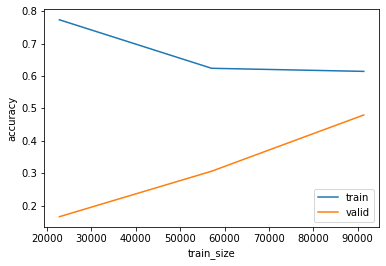

In [147]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.